In [37]:
# Imports
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from statsmodels.tsa.seasonal import seasonal_decompose
from keras.models import Sequential
from keras.layers import LSTM, Dense, Flatten
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

In [38]:
# Get raw data
def get_raw_data(path):
    df = pd.read_excel(path, index_col=0)
    print(df.head(3))
    return df

raw_data = get_raw_data('../data/raw_data/cascaded_use_case_data.xlsx')

                     Vindhastighet Nilsebu  Lufttemp. Nilsebu  \
Datetime                                                        
2015-01-01 00:00:00                    6.4                1.5   
2015-01-01 01:00:00                    5.8                1.9   
2015-01-01 02:00:00                    6.1                1.6   

                     Vindretning Nilsebu  RelHum Nilsebu  Vannstand Lyngsåna  \
Datetime                                                                       
2015-01-01 00:00:00                200.0            97.3               0.699   
2015-01-01 01:00:00                197.5            95.0               0.700   
2015-01-01 02:00:00                205.3            96.7               0.714   

                     Vanntemp. Hiafossen  Vannstand Hiafossen  \
Datetime                                                        
2015-01-01 00:00:00                  0.9                0.945   
2015-01-01 01:00:00                  0.9                0.946   
2015-01-01 02

In [39]:
target = raw_data[['Q_Kalltveit']]
target.index = pd.to_datetime(target.index)
target.rolling(24).mean().iplot()

In [40]:
scaler = MinMaxScaler()
data = target.values
scaler.fit(data)
scaled_data = scaler.transform(data)

In [41]:
def prepare_data(timeseries_data, n_features):
    X, y = [], []
    for i in range(len(timeseries_data)):
        end_idx = i + n_features
        if end_idx > len(timeseries_data) - 1:
            break
        seq_x, seq_y = timeseries_data[i:end_idx], timeseries_data[end_idx]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)
n_features = 12
X, y = prepare_data(target.values, n_features)

In [42]:
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=int(len(target)*0.2), shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, test_size=int(len(X_test_val)*0.3), shuffle=False)
X_train.shape, X_val.shape, X_test.shape

((50619, 12, 1), (8860, 12, 1), (3797, 12, 1))

In [43]:
model_1 = Sequential()
model_1.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(n_features, 1)))
model_1.add(LSTM(64, activation='relu'))
model_1.add(Dense(1))
model_1.compile(optimizer='adam', loss='mse')
model_1.fit(X_train, y_train, epochs=20, verbose=1, validation_data=(X_val, y_val))

Epoch 1/20
1582/1582 [==============================] - 12s 6ms/step - loss: 3.4942 - val_loss: 1.2587
Epoch 2/20
1582/1582 [==============================] - 10s 6ms/step - loss: 0.5947 - val_loss: 0.2110
Epoch 3/20
1582/1582 [==============================] - 10s 6ms/step - loss: 0.8256 - val_loss: 0.6060
Epoch 4/20
1582/1582 [==============================] - 10s 6ms/step - loss: 1.2767 - val_loss: 0.1622
Epoch 5/20
1582/1582 [==============================] - 9s 6ms/step - loss: 0.4470 - val_loss: 0.1087
Epoch 6/20
1582/1582 [==============================] - 9s 6ms/step - loss: 0.1973 - val_loss: 0.0966
Epoch 7/20
1582/1582 [==============================] - 9s 6ms/step - loss: 0.3240 - val_loss: 0.1273
Epoch 8/20
1582/1582 [==============================] - 9s 6ms/step - loss: 0.3361 - val_loss: 0.2340
Epoch 9/20
1582/1582 [==============================] - 9s 6ms/step - loss: 0.6127 - val_loss: 0.1730
Epoch 10/20
1582/1582 [==============================] - 9s 6ms/step - loss: 0

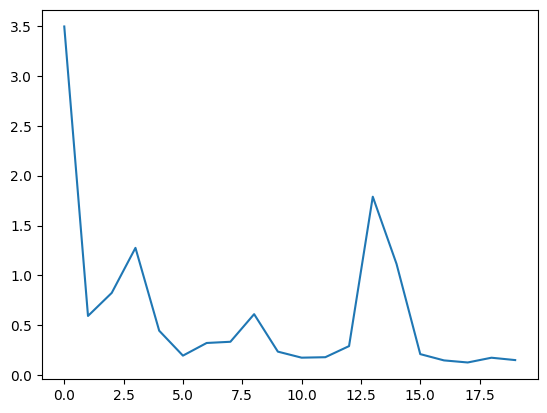

In [44]:
loss_per_epoch = model_1.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

In [45]:
test_predictions_1 = model_1.predict(X_test).flatten()

119/119 [==============================] - 1s 3ms/step


In [46]:
print("Mean Absolute Error Model 1:", mean_absolute_error(y_test, test_predictions_1))

Mean Absolute Error Model 1: 0.13767813511678412


In [47]:
s = pd.DataFrame(scaler.inverse_transform(test_predictions_1.reshape(-1, 1)))
true_values = pd.DataFrame(scaler.inverse_transform(y_test.reshape(-1, 1)))

In [48]:
idx = target.index[len(target)-len(true_values):]
s.index = idx.values
true_values.index = idx.values

In [49]:
df = pd.concat([s, true_values], axis=1)
df.columns = ['predicted', 'true']
df.iplot()

In [50]:
from keras.layers import Conv2D, MaxPool2D, Dropout, MaxPooling1D, Conv1D

model_2 = Sequential()
model_2.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_features, 1)))
model_2.add(MaxPooling1D(pool_size=2))
model_2.add(Flatten())
model_2.add(Dense(50, activation='relu'))
model_2.add(Dense(1))
model_2.compile(optimizer='adam', loss='mse')
model_2.fit(X_train, y_train, epochs=20, verbose=1, validation_data=(X_val, y_val))

Epoch 1/20
1582/1582 [==============================] - 2s 1ms/step - loss: 2.4509 - val_loss: 0.7162
Epoch 2/20
1582/1582 [==============================] - 1s 906us/step - loss: 1.3523 - val_loss: 0.7221
Epoch 3/20
1582/1582 [==============================] - 1s 915us/step - loss: 1.3120 - val_loss: 0.7749
Epoch 4/20
1582/1582 [==============================] - 1s 930us/step - loss: 1.1833 - val_loss: 0.6939
Epoch 5/20
1582/1582 [==============================] - 1s 946us/step - loss: 1.1549 - val_loss: 0.6862
Epoch 6/20
1582/1582 [==============================] - 1s 919us/step - loss: 1.1479 - val_loss: 0.7383
Epoch 7/20
1582/1582 [==============================] - 1s 915us/step - loss: 1.1316 - val_loss: 0.6346
Epoch 8/20
1582/1582 [==============================] - 2s 954us/step - loss: 1.0926 - val_loss: 0.9213
Epoch 9/20
1582/1582 [==============================] - 1s 918us/step - loss: 1.1168 - val_loss: 0.6359
Epoch 10/20
1582/1582 [==============================] - 1s 893us/

In [51]:
test_predictions_2 = model_2.predict(X_test).flatten()
print("Mean Absolute Error Model 2:", mean_absolute_error(y_test, test_predictions_2))
s = pd.DataFrame(scaler.inverse_transform(test_predictions_2.reshape(-1, 1)))
true_values = pd.DataFrame(scaler.inverse_transform(y_test.reshape(-1, 1)))
idx = target.index[len(target) - len(true_values):]
s.index = idx.values
true_values.index = idx.values
df = pd.concat([s, true_values], axis=1)
df.columns = ['predicted', 'true']
df.iplot()

119/119 [==============================] - 0s 610us/step
Mean Absolute Error Model 2: 0.3619308218559404


In [52]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
x = [x[0] for x in X_train]
y = [y[0] for y in y_train]

lr.fit(x, y)

LinearRegression()

In [53]:
predictions = lr.predict([x[0] for x in X_test])
print("Mean Absolute Error Model 3:", mean_absolute_error([y[0] for y in y_test], predictions))
s = pd.DataFrame(scaler.inverse_transform(predictions.reshape(-1, 1)))
true_values = pd.DataFrame(scaler.inverse_transform(y_test.reshape(-1, 1)))
idx = target.index[len(target) - len(true_values):]
s.index = idx.values
true_values.index = idx.values
df = pd.concat([s, true_values], axis=1)
df.columns = ['predicted', 'true']
df.iplot()

Mean Absolute Error Model 3: 2.843093839120549
